In [1]:
import librosa, torch, IPython, io, PIL, librosa, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import  cm
from utils import polarToComplex, complexToPolar, reconstructAudioFromBatches
import soundfile as sf

%matplotlib inline

## Testing the whole reconstruction using mag and phase

In [4]:
wav="../datadrive/ljwitcher/revWavs/LJ001-0048.wav"
#his letter is admirably clear and regular, but at least as beautiful as any other Roman type
# wav="../datadrive/random/reverbed/CA02_05.wav"
# wav="../../reverberant_speech_classroom.wav"
# wav="../../ML70_06.wav"
# wav="../../ML69_09.wav"
# wav="../../ML69_08-rir-0.6-r2.wav"
# wav="../../MH43_02-rir-0.6-r2.wav"
# wav="../../MD22_02.wav"
# wav="../../LJ019-0132.wav"
# wav="../../FA01_03.wav"
# wav="../../audio000.wav"

In [5]:
stftParams={
    "window":'hamming',
    "n_fft":512,
    "win_length":32,
}
istftParams={key:val for key, val in stftParams.items() if key!="n_fft"}

In [6]:
audio, _=librosa.load(wav, sr=16000)
stft=librosa.stft(audio, **stftParams)
rec=librosa.istft(stft, **istftParams)
sum(audio[:len(rec)] - rec)
mag, phase=complexToPolar(stft)
complex=polarToComplex(mag, phase)
rec1=librosa.istft(stft, **istftParams)
# rec1=librosa.istft(stft)
IPython.display.Audio(rec1, rate=16000)

## Testing reconstruction from model output

In [7]:
def transform(X):
    return (X - X.min()) / (X.max() - X.min())
def split(array):
    """Accepts numpy array of shape [x, y] returns squared arrays split along y-axis"""
    xdim=array.shape[0]//2*2
    ydim=array.shape[1]
    ydimHead=ydim//xdim*xdim #y-dim of the initial batches
    ydimTail=ydim-ydim//xdim*xdim # y-dim of the last batch 
    batches=np.asarray(np.hsplit(array[:xdim,:ydimHead], ydim//xdim))
    
    
    #pad the last batch with minimum value of spectrogram
    tailBatch=array[:xdim, ydimHead:]
    tailB=np.full((xdim, xdim), array.min())
    tailB[:, :ydimTail]=tailBatch
    batches=np.concatenate((batches, np.expand_dims(tailB, axis=0)), axis=0)
    batches=transform(batches)
    return np.expand_dims(batches, axis=1)

In [8]:
magBatch=split(mag)
phaseBatch=split(phase)
magBatch.shape
orgAudio=reconstructAudioFromBatches(np.abs(magBatch), phaseBatch, istftParams)

# Loading model

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, channelUp, channelDown):
        super(Attention, self).__init__()
        self.interShape=int((channelUp+channelDown)/2)
        self.deconv1 = nn.ConvTranspose2d(channelDown, self.interShape, kernel_size=1, stride=1)
        self.conv1 = nn.Conv2d(channelUp, self.interShape, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(self.interShape, 1, kernel_size=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.deconv2=nn.ConvTranspose2d(self.interShape, channelUp, kernel_size=2, stride=2)
        self.bn=nn.BatchNorm2d(num_features=channelUp)
        self.interpolate=lambda a: a.repeat((1, self.interShape, 1, 1))

    def forward(self, x, g):
        x=self.conv1(x)
        addition = self.deconv1(g) + x
        addition = self.relu(addition)
        addition = self.conv2(addition)
        attention = self.sigmoid(addition)
        attentionC=self.interpolate(attention)
        temp=input("input: ")
        if temp=='c':
            x = x.mul(attentionC)
            x = self.deconv2(x)
            return self.bn(x)
        else:
            return attention


class CBL(nn.Module):
    """Conv -> BN -> ReLU"""

    def __init__(self, inChannels, outChannels, midChannels=None):
        super(CBL, self).__init__()
        if not midChannels:
            midChannels = outChannels
        self.cbl = nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=midChannels, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=midChannels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)

            # The original U-net paper used two layers of CBL

            # nn.Conv2d(in_channels=midChannels, out_channels=outChannels, kernel_size=5, padding=2),
            # nn.BatchNorm2d(num_features=outChannels),
            # nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, input_):
        return self.cbl(input_)


class Upsample(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels=inChannels, out_channels=inChannels // 2, kernel_size=5,
                                           stride=2)
        self.conv = CBL(inChannels, outChannels)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, inChannels, outChannels, maxpool=True):
        super(Downsample, self).__init__()
        self.isMaxpool = maxpool
        self.CBL = CBL(inChannels, outChannels)
        self.maxpool = nn.MaxPool2d(2)
        self.maxpoolConv = nn.Sequential(
            nn.MaxPool2d(2),
            CBL(inChannels, outChannels)
        )

    def forward(self, input_):
        if self.maxpool:
            return self.maxpool(self.CBL(input_))
        return self.CBL(input_)


class OutConv(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(inChannels, outChannels, kernel_size=1)
        self.sigm = nn.Sigmoid()

    def forward(self, input_):
        return self.sigm(self.conv(input_))


class UNet(nn.Module):
    def __init__(self, nChannels, nClasses, dropout=0.5):
        super(UNet, self).__init__()
        self.nChannels = nChannels
        self.nClasses = nClasses
        self.DCT = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=5, stride=2),
            nn.Tanh()
        )

        self.dropout = nn.Dropout(dropout)
        self.inc = CBL(nChannels, 16)
        self.down1 = Downsample(16, 32)
        #self.attention1=Attention(16, 32)
        self.down2 = Downsample(32, 64)
        #self.attention2=Attention(32, 64)
        self.down3 = Downsample(64, 128)
        self.attention3=Attention(64, 128)
        self.down4 = Downsample(128, 256)
        #self.attention4=Attention(128, 256)
        self.down5 = Downsample(256, 512)
        self.attention5=Attention(256, 512)
        self.up1 = Upsample(512, 256)
        self.up2 = Upsample(256, 128)
        self.up3 = Upsample(128, 64)
        self.up4 = Upsample(64, 32)
        self.up5 = Upsample(32, 16)
        self.up6 = OutConv(16, nClasses)

    def forward(self, x_):
        # C H W 1x256x256
        x1 = self.inc(x_) #16x256x256
        x2 = self.down1(x1) #32x128x128
        x3 = self.down2(x2) #64x64x64
        x4 = self.down3(x3) #128x32x32
        x5 = self.down4(x4) #256x16x16
        x6 = self.down5(x5) #512x8x8
        x = self.up1(x6, self.attention5(x5, x6)) #256
        x=self.up2(x, x4)
        #x = self.up2(x, self.attention4(x4, x5)) #128
        #x=self.up3(x, x3)
        x = self.up3(x, self.attention3(x3, x4)) #64
        breakpoint()
        return x, self.attention3(x3, x4)
        x=self.up4(x, x2)
        x=self.up5(x, x1)
        #x = self.up4(x, self.attention2(x2, x3)) #32
        #x = self.up5(x, self.attention1(x1, x2)) #16
        output = self.up6(x) #1
        return output


In [72]:
# checkpoint="/Users/zombie/Downloads/datadrive/17k.pt"
# checkpoint="checkpoints/13kB.pt"
# checkpoint="checkpoints/nn18k3B_final.pt"
# checkpoints="../../1MSE12k.pt"
# checkpoint="../datadrive/newunet2_6k.pt"
# checkpoint="../checkpoints/newExp3_36k.pt"
# checkpoint="newExpsmallCheckpoint.pt"
# checkpoint="/Users/zombie/diceBCE11k.pt"
# from unet import UNet
net=UNet(1,1)
# ckp=torch.load(checkpoint, map_location='cpu')
# net.load_state_dict(ckp['modelStateDict'])
# net.eval()
# print('loaded')
checkpoint="newExpsmallCheckpoint.pt"
# checkpoint="/Users/zombie/diceBCE11k.pt"

ckp=torch.load(checkpoint, map_location='cpu')
net.load_state_dict(ckp['modelStateDict'])
net.eval()
print('loaded')

loaded


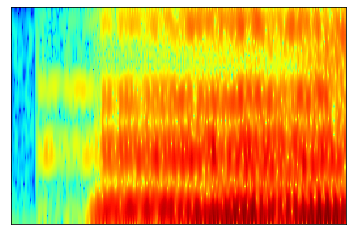

In [73]:
librosa.display.specshow(librosa.power_to_db(magBatch[0][0]), cmap=cm.jet)

In [74]:
from torchsummary import summary
from utils import countParams

In [75]:
out=net(torch.from_numpy(magBatch))

input:  c
input:  c


> <ipython-input-71-88a907e9ce6b>(144)forward()
    142         x = self.up3(x, self.attention3(x3, x4)) #64
    143         breakpoint()
--> 144         return x, self.attention3(x3, x4)
    145         x=self.up4(x, x2)
    146         x=self.up5(x, x1)



ipdb>  c
input:  j


In [76]:
out[1].shape

torch.Size([62, 1, 32, 32])

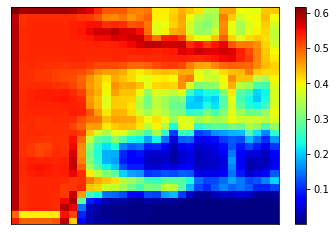

In [77]:
plt.figure()
librosa.display.specshow(out[1][0][0].detach().numpy(), cmap=cm.jet)
plt.colorbar()

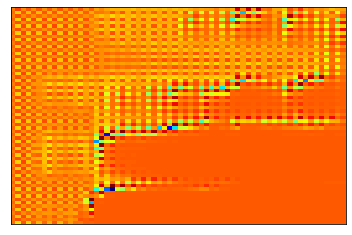

In [53]:
librosa.display.specshow(librosa.power_to_db(nn.Sigmoid()(out[1][0][0]).detach().numpy()), cmap=cm.jet)

In [30]:
summary(net, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             416
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         LeakyReLU-3         [-1, 16, 256, 256]               0
               CBL-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 32, 256, 256]          12,832
       BatchNorm2d-6         [-1, 32, 256, 256]              64
         LeakyReLU-7         [-1, 32, 256, 256]               0
               CBL-8         [-1, 32, 256, 256]               0
         MaxPool2d-9         [-1, 32, 128, 128]               0
       Downsample-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          51,264
      BatchNorm2d-12         [-1, 64, 128, 128]             128
        LeakyReLU-13         [-1, 64, 128, 128]               0
              CBL-14         [-1, 64, 1